In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima.model import ARIMA
register_matplotlib_converters()
from time import time

# Catfish Sales Data

In [2]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

In [ ]:
#read data
catfish_sales = pd.read_csv('catfish.csv', 
                            parse_dates=[0], 
                            index_col=0, 
                            # squeeze=True, 
                            date_parser=parser)

if catfish_sales.shape[1] == 1:
    catfish_sales = catfish_sales.iloc[:, 0].squeeze()
else:
    catfish_sales = catfish_sales.squeeze()
    
catfish_sales

Date
1986-1-01      9034
1986-2-01      9596
1986-3-01     10558
1986-4-01      9002
1986-5-01      9239
              ...  
2012-8-01     14442
2012-9-01     13422
2012-10-01    13795
2012-11-01    13352
2012-12-01    12716
Name: Total, Length: 324, dtype: int64

In [4]:
#infer the frequency of the data
catfish_sales = catfish_sales.asfreq(pd.infer_freq(catfish_sales.index))
catfish_sales

Date
1986-01-01   NaN
1986-02-01   NaN
1986-03-01   NaN
1986-04-01   NaN
1986-05-01   NaN
              ..
2012-05-01   NaN
2012-06-01   NaN
2012-07-01   NaN
2012-08-01   NaN
2012-09-01   NaN
Freq: MS, Name: Total, Length: 321, dtype: float64

In [5]:
import plotly.express as px

fig = px.line(catfish_sales)
fig.show()

In [6]:
start_date = datetime(2000,1,1)
end_date = datetime(2004,1,1)
lim_catfish_sales = catfish_sales[start_date:end_date]
lim_catfish_sales.shape

(49,)

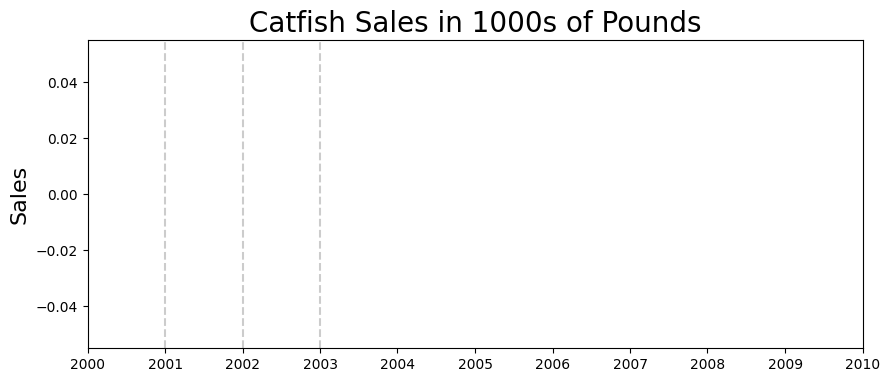

In [7]:
plt.figure(figsize=(10,4))
plt.plot(lim_catfish_sales)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axhline(lim_catfish_sales.mean(), color='r', alpha=0.2, linestyle='--')

In [8]:
first_diff = lim_catfish_sales.diff()[1:]
first_diff.shape

(48,)

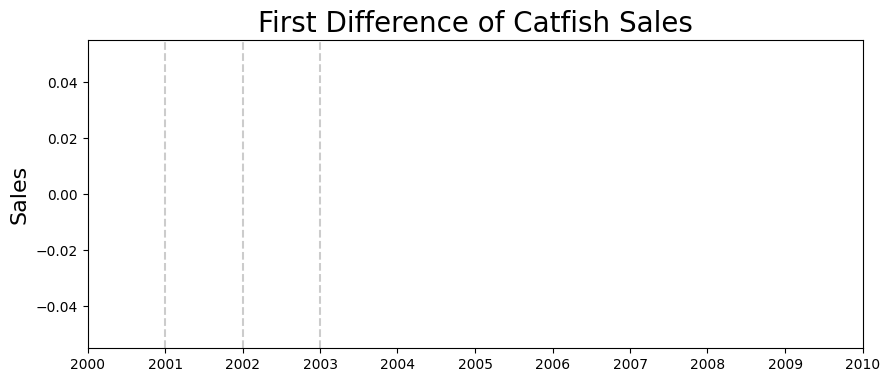

In [9]:
plt.figure(figsize=(10,4))
plt.plot(first_diff)
plt.title('First Difference of Catfish Sales', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axhline(first_diff.mean(), color='r', alpha=0.2, linestyle='--')

# ACF

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]


<BarContainer object of 17 artists>

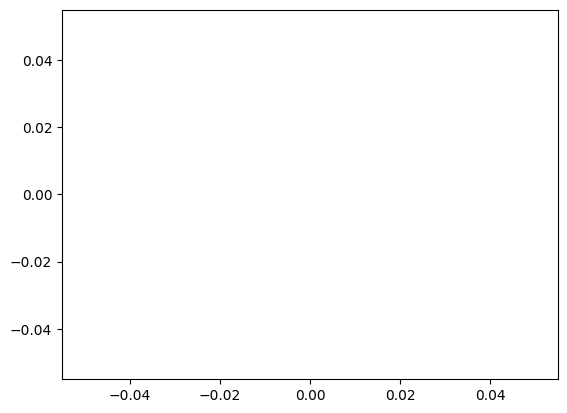

In [10]:
num_lags = 17

acf_vals = acf(first_diff)
print(acf_vals)
plt.bar(range(num_lags), acf_vals[:num_lags])

## Based on ACF, we should start with a MA(1) process

# PACF

<BarContainer object of 17 artists>

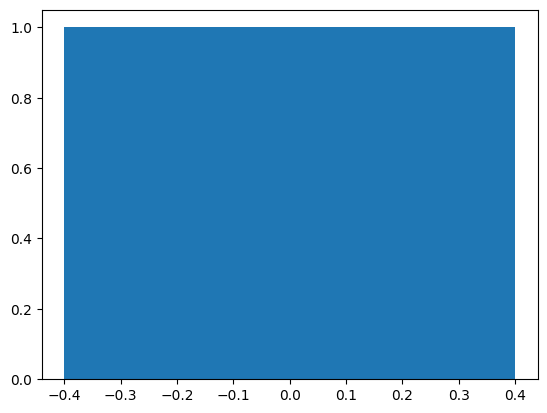

In [11]:
pacf_vals = pacf(first_diff)
plt.bar(range(num_lags), pacf_vals[:num_lags])

## Based on PACF, we should start with a AR(4) process

# Get training and testing sets

In [12]:
train_end = datetime(2003,7,1)
test_end = datetime(2004,1,1)

train_data = first_diff[:train_end]
test_data = first_diff[train_end + timedelta(days=1):test_end]

# Fit the ARMA Model

In [13]:
# define model
# model = ARMA(train_data, order=(4,1))
model = ARIMA(train_data, order=(4,0,1))

In [14]:
#fit the model
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

Model Fitting Time: 0.006972789764404297


/Users/alanwong/miniconda3/envs/crypto/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.



In [15]:
#summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Total   No. Observations:                   42
Model:                 ARIMA(4, 0, 1)   Log Likelihood                   0.000
Date:                Tue, 09 Sep 2025   AIC                             14.000
Time:                        17:18:33   BIC                             26.164
Sample:                    02-01-2000   HQIC                            18.458
                         - 07-01-2003                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const               0         -0        nan        nan           0           0
ar.L1              -0         -0        nan        nan           0          -0
ar.L2              -0         -0        nan        n

/Users/alanwong/miniconda3/envs/crypto/lib/python3.12/site-packages/statsmodels/tsa/statespace/mlemodel.py:3016: RuntimeWarning:

divide by zero encountered in divide

/Users/alanwong/miniconda3/envs/crypto/lib/python3.12/site-packages/statsmodels/tsa/statespace/mlemodel.py:3016: RuntimeWarning:

invalid value encountered in divide

/Users/alanwong/miniconda3/envs/crypto/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1431: RuntimeWarning:

invalid value encountered in divide

/Users/alanwong/miniconda3/envs/crypto/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:702: RuntimeWarning:

invalid value encountered in divide



## So the ARMA(4,1) model is:

## $\hat{y_t} = -0.87y_{t-1} - 0.42y_{t-2} - 0.56y_{t-3} - 0.61y_{t-4} + 0.52\varepsilon_{t-1}$

In [16]:
#get prediction start and end dates
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

In [17]:
#get the predictions and residuals
predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)
residuals = test_data - predictions

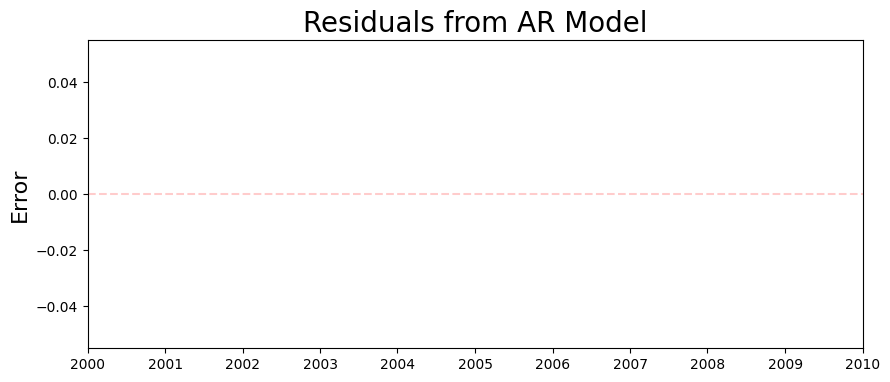

In [18]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title('Residuals from AR Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)

Text(0, 0.5, 'Sales')

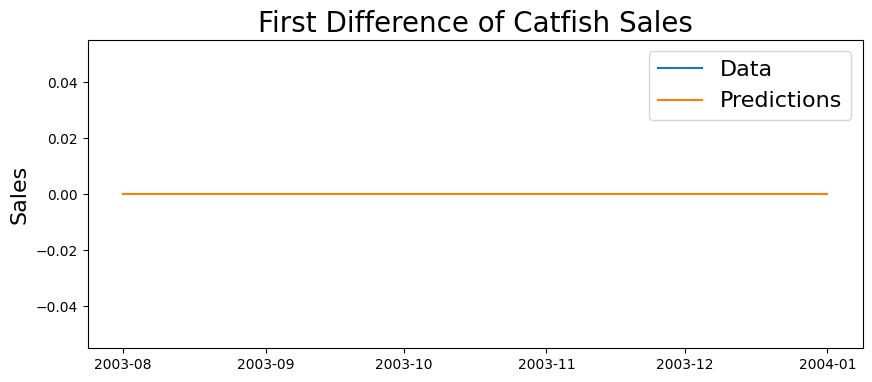

In [19]:
plt.figure(figsize=(10,4))

plt.plot(test_data)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('First Difference of Catfish Sales', fontsize=20)
plt.ylabel('Sales', fontsize=16)

In [20]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: nan
